In [47]:
# import pandas
import pandas as pd
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing


In [66]:
df = pd.read_csv('100kexperiment.csv')

In [49]:
for col in df.columns:
    if col == 'Asked':
        x = df[col].values
        v = []
        for val in x:
            val = val*100
            v.append(val)
        x = np.array(v).reshape(-1, 1)
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df[col] = x_scaled
    elif col != 'Score':
        x = df[col].values.reshape(-1, 1)
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df[col] = x_scaled
    else:
        x = df[col].values
        v = []
        for val in x:
            val = val*100
            v.append(val)
        x = np.array(v).reshape(-1, 1)
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df[col] = x_scaled

In [67]:
df

,Interactions,User_Picked,Cost,HPFS,Known_Defects,Features_Used,Score
0,9.0,10.0,231.0,60.00,36.0,31.0,0.0010
1,9.0,9.0,229.0,66.60,36.0,33.0,0.0015
2,9.0,12.0,229.0,66.60,36.0,33.0,0.0010
3,9.0,12.0,229.0,66.60,36.0,33.0,0.0010
4,9.0,7.0,234.0,71.40,36.0,30.0,0.0010
5,9.0,10.0,228.0,70.00,35.0,30.0,0.0010
6,9.0,9.0,230.0,66.60,35.0,30.0,0.0010
7,9.0,11.0,228.0,54.50,35.0,30.0,0.0010
8,9.0,11.0,229.0,63.60,36.0,31.0,0.0010
9,9.0,10.0,232.0,70.00,36.0,31.0,0.0010


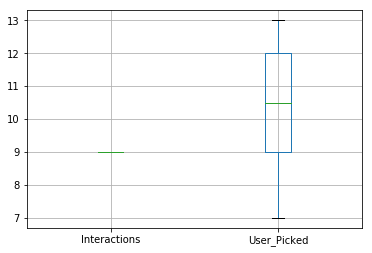

In [68]:
boxplot = df.boxplot(column=['Interactions', 'User_Picked'])

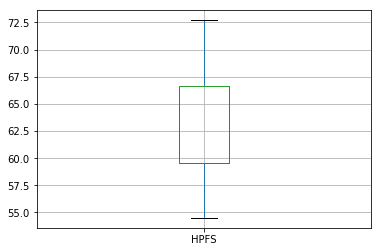

In [69]:
boxplot = df.boxplot(column=['HPFS'])

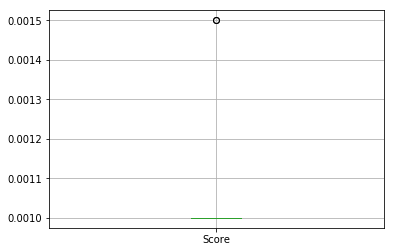

In [70]:
boxplot = df.boxplot(column=['Score'])

In [5]:
from copy import deepcopy as kopy
import sys
import random

"""
Scott-Knot test + non parametric effect size + significance tests.
Tim Menzies, 2019. Share and enjoy. No warranty. Caveat Emptor.
Accepts data as per the following exmaple (you can ignore the "*n"
stuff, that is just there for the purposes of demos on larger
and larger data)
Ouputs treatments, clustered such that things that have similar
results get the same ranks.
"""


# -----------------------------------------------------
# Examples

def skDemo(n=5):
    # Rx.data is one way to run the code
    return Rx.data(x1=[0.34, 0.49, 0.51, 0.6] * n,
                   x2=[0.6, 0.7, 0.8, 0.89] * n,
                   x3=[0.13, 0.23, 0.38, 0.38] * n,
                   x4=[0.6, 0.7, 0.8, 0.9] * n,
                   x5=[0.1, 0.2, 0.3, 0.4] * n)


"""
Another is to make a file
x1  0.34  0.49  0.51  0.6
x2  0.6   0.7   0.8   0.9
x3  0.15  0.25  0.4   0.35
x4  0.6   0.7   0.8   0.9
x5  0.1   0.2   0.3   0.4
Then call 
   Rx.fileIn( fileName )
"""


# -----------------------------------------------------
# Config

class o:
    def __init__(i, **d): i.__dict__.update(**d)


class THE:
    cliffs = o(dull=[0.147,  # small
                     0.33,  # medium
                     0.474  # large
                     ][0])
    bs = o(conf=0.05,
           b=500)
    mine = o(private="_")
    char = o(skip="?")
    rx = o(show="%4s %10s %s")
    tile = o(width=50,
             chops=[0.1, 0.3, 0.5, 0.7, 0.9],
             marks=[" ", "-", "-", "-", " "],
             bar="|",
             star="*",
             show=" %5.3f")


# -----------------------------------------------------
def cliffsDeltaSlow(lst1, lst2, dull=THE.cliffs.dull):
    """Returns true if there are more than 'dull' difference.
       Warning: O(N)^2."""
    n = gt = lt = 0.0
    for x in lst1:
        for y in lst2:
            n += 1
            if x > y:
                gt += 1
            if x < y:
                lt += 1
    return abs(lt - gt) / n <= dull


def cliffsDelta(lst1, lst2, dull=THE.cliffs.dull):
    "By pre-soring the lists, this cliffsDelta runs in NlogN time"

    def runs(lst):
        for j, two in enumerate(lst):
            if j == 0:
                one, i = two, 0
            if one != two:
                yield j - i, one
                i = j
            one = two
        yield j - i + 1, two

    # ---------------------
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j * repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j) * repeats
    d = (more - less) / (m * n)
    return abs(d) <= dull


def bootstrap(y0, z0, conf=THE.bs.conf, b=THE.bs.b):
    """
    two  lists y0,z0 are the same if the same patterns can be seen in all of them, as well
    as in 100s to 1000s  sub-samples from each.
    From p220 to 223 of the Efron text  'introduction to the boostrap'.
    Typically, conf=0.05 and b is 100s to 1000s.
    """

    class Sum():
        def __init__(self, some=None):
            if some is None:
                some = []
            self.sum = self.n = i.mu = 0
            self.all = []
            for one_ in some:
                self.put(one_)

        def put(self, x):
            self.all.append(x)
            self.sum += x
            self.n += 1
            self.mu = float(self.sum) / self.n

        def __add__(self, i2): return Sum(self.all + i2.all)

    def test_statistic(y, z):
        tmp1 = tmp2 = 0
        for y1 in y.all:
            tmp1 += (y1 - y.mu) ** 2
        for z1 in z.all:
            tmp2 += (z1 - z.mu) ** 2
        s1 = float(tmp1) / (y.n - 1)
        s2 = float(tmp2) / (z.n - 1)
        delta = z.mu - y.mu
        if s1 + s2:
            delta = delta / ((s1 / y.n + s2 / z.n) ** 0.5)
        return delta

    def one(lst):
        return lst[int(random.uniform(0, (len(lst))))]

    y, z = Sum(y0), Sum(z0)
    x = y + z
    yhat = [y1 - y.mu + x.mu for y1 in y.all]
    zhat = [z1 - z.mu + x.mu for z1 in z.all]
    bigger = 0
    for i in range(b):
        if test_statistic(Sum([one(yhat) for _ in yhat]),
                          Sum([one(zhat) for _ in zhat])) > test_statistic(y, z):
            bigger += 1
    return bigger / b >= conf


# -------------------------------------------------------
# misc functions
def same(x): return x


class Mine:
    "class that, amongst other times, pretty prints objects"
    oid = 0

    def identify(i):
        Mine.oid += 1
        i.oid = Mine.oid
        return i.oid

    def __repr__(i):
        pre = i.__class__.__name__ + '{'

        def q(z):
            if isinstance(z, str):
                return "'%s'" % z
            if callable(z):
                return "fun(%s)" % z.__name__
            return str(z)

        return pre + ", ".join(['%s=%s' % (k, q(v))])


# -------------------------------------------------------
class Rx(Mine):
    "place to manage pairs of (TreatmentName,ListofResults)"

    def __init__(self, rx="", vals=None):
        if vals is None:
            vals = []
        self.rx = rx
        self.vals = sorted([x for x in vals if x != THE.char.skip])
        self.n = len(self.vals)
        self.med = self.vals[int(self.n / 2)]
        self.mu = sum(self.vals) / self.n
        self.rank = 1

    def tiles(self, lo=0, hi=1):
        return xtile(self.vals, lo, hi)

    def __lt__(i, j):
        return i.med < j.med

    def __eq__(i, j):
        return cliffsDelta(i.vals, j.vals)  # and \
        # bootstrap(i.vals,j.vals)

    def __repr__(i):
        return '%4s %10s %s' % (i.rank, i.rx, i.tiles())

    def xpect(i, j, b4):
        "Expected value of difference in emans before and after a split"
        n = i.n + j.n
        return i.n / n * (b4.med - i.med) ** 2 + j.n / n * (j.med - b4.med) ** 2

    # -- end instance methods --------------------------

    @staticmethod
    def data(**d):
        "convert dictionary to list of treatments"
        return [Rx(k, v) for k, v in d.items()]

    @staticmethod
    def fileIn(f):
        d = {}
        what = None
        for word in words(f):
            x = thing(word)
            if isinstance(x, str):
                what = x
                d[what] = d.get(what, [])
            else:
                d[what] += [x]
        Rx.show(Rx.sk(Rx.data(**d)))

    @staticmethod
    def sum(rxs):
        "make a new rx from all the rxs' vals"
        all_ = []
        for rx in rxs:
            for val in rx.vals:
                all_ += [val]
        return Rx(vals=all_)

    @staticmethod
    def show(rxs):
        "pretty print set of treatments"
        for rx in sorted(rxs):
            print(THE.rx.show % (rx.rank, rx.rx, rx.tiles()))

    @staticmethod
    def sk(rxs):
        "sort treatments and rank them"

        def divide(lo, hi, b4, rank):
            cut = left = right = None
            best = 0
            for j in range(lo + 1, hi):
                left0 = Rx.sum(rxs[lo:j])
                right0 = Rx.sum(rxs[j:hi])
                now = left0.xpect(right0, b4)
                if now > best:
                    if left0 != right0:
                        best, cut, left, right = now, j, kopy(
                            left0), kopy(right0)
            if cut:
                rank = divide(lo, cut, left, rank) + 1
                rank = divide(cut, hi, right, rank)
            else:
                for rx in rxs[lo:hi]:
                    rx.rank = rank
            return rank

        # -- sk main
        rxs = sorted(rxs)
        divide(0, len(rxs), Rx.sum(rxs), 1)
        return rxs


# -------------------------------------------------------
def pairs(lst):
    "Return all pairs of items i,i+1 from a list."
    last = lst[0]
    for i in lst[1:]:
        yield last, i
        last = i


def words(f):
    with open(f) as fp:
        for line in fp:
            for word in line.split(','):
                yield word


def xtile(lst, lo, hi,
          width=THE.tile.width,
          chops=THE.tile.chops,
          marks=THE.tile.marks,
          bar=THE.tile.bar,
          star=THE.tile.star,
          show=THE.tile.show):
    """The function _xtile_ takes a list of (possibly)
    unsorted numbers and presents them as a horizontal
    xtile chart (in ascii format). The default is a
    contracted _quintile_ that shows the
    10,30,50,70,90 breaks in the data (but this can be
    changed- see the optional flags of the function).
    """

    def pos(p):
        return ordered[int(len(lst) * p)]

    def place(x):
        return int(width * float((x - lo)) / (hi - lo + 0.00001))

    def pretty(lst):
        return ', '.join([show % x for x in lst])

    ordered = sorted(lst)
    lo = min(lo, ordered[0])
    hi = max(hi, ordered[-1])
    what = [pos(p) for p in chops]
    where = [place(n) for n in what]
    out = [" "] * width
    for one, two in pairs(where):
        for i in range(one, two):
            out[i] = marks[0]
        marks = marks[1:]
    out[int(width / 2)] = bar
    out[place(pos(0.5))] = star
    return '(' + ''.join(out) + ")," + pretty(what)


def thing(x):
    "Numbers become numbers; every other x is a symbol."
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return x


# -------------------------------------------------------
def _cliffsDelta():
    "demo function"
    lst1 = [1, 2, 3, 4, 5, 6, 7] * 100
    n = 1
    for _ in range(10):
        lst2 = [x * n for x in lst1]
        print(cliffsDelta(lst1, lst2), n)  # should return False
        n *= 1.03


def bsTest(n=1000, mu1=10, sigma1=1, mu2=10.2, sigma2=1):
    def g(mu, sigma): return random.gauss(mu, sigma)

    x = [g(mu1, sigma1) for i in range(n)]
    y = [g(mu2, sigma2) for i in range(n)]
    return n, mu1, sigma1, mu2, sigma2, \
        'same' if bootstrap(x, y) else 'different'


# -------------------------------------------------------

In [11]:
Rx.fileIn('Scores10k.csv')

   1      Score (*                        |                        ), 0.010,  0.010,  0.010,  0.010,  0.015
